Yêu cầu 1: Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.

**1. Đọc tập dữ liệu KDD99**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file
path = "/content/kddcup.data_10_percent.txt"


print(path)

/content/kddcup.data_10_percent.txt


Xóa đi dòng 485798 của file csv

In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494020 rows.


In [ ]:
# CSV không có header , lấy từ file kddname
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

# Liệt kê các giá trị duy nhất trong cột 'outcome'
unique_outcomes = df['outcome'].unique()

# Hiển thị các giá trị duy nhất
print(unique_outcomes)

['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


# **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494020, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97277
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

# **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-64-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-64-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-64-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [ ]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [ ]:
# df.loc[df["outcome"] != "normal.", "outcome"] = 1
# df.loc[df["outcome"] == "normal.", "outcome"] = 0

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['outcome'] = label_encoder.fit_transform(df['outcome'])

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.2, random_state=48)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((395216, 120), (395216,))
Normal test count: ((98804, 120), (98804,))


In [ ]:
num_classes = len(np.unique(y_train))
y_train = tf.one_hot(y_train.values, num_classes)
y_test = tf.one_hot(y_test.values, num_classes)

**4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 23)                1495      
                                                                 
Total params: 18391 (71.84 KB)
Trainable params: 18391 (71.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import numpy as np

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)


In [ ]:
x_train

array([[-0.06779172, -0.00253549, -0.02628722, ...,  1.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00201738, -0.02628722, ...,  1.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00201738, -0.02628722, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.06779172, -0.00253549, -0.02628722, ...,  1.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00306169, -0.02628722, ...,  1.        ,
         1.        ,  0.        ],
       [-0.06779172, -0.00235739, -0.01629934, ...,  1.        ,
         1.        ,  0.        ]], dtype=float32)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**5. Huấn luyện mô hình**

Sử dụng EarlyStopping để tránh overfit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False,
    callbacks=[early_stopping]
)

Epoch 1/3
309/309 [==============================] - 253s 807ms/step - loss: 0.0274 - accuracy: 0.5588 - val_loss: 0.0358 - val_accuracy: 0.5716
Epoch 2/3
309/309 [==============================] - 254s 820ms/step - loss: 0.0082 - accuracy: 0.8924 - val_loss: 0.0019 - val_accuracy: 0.9766
Epoch 3/3
309/309 [==============================] - 249s 806ms/step - loss: 0.0058 - accuracy: 0.9301 - val_loss: 0.0019 - val_accuracy: 0.9777


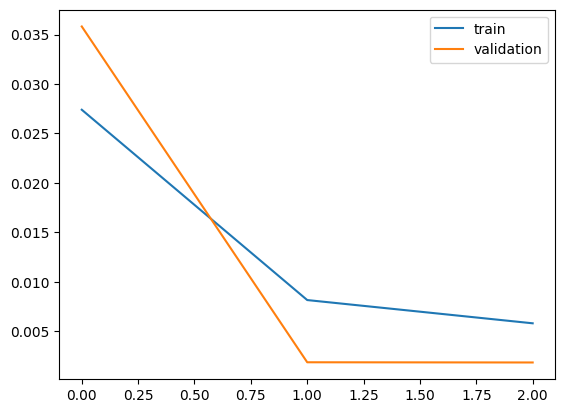

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

**6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

386/386 [==============================] - 149s 387ms/step - loss: 0.0018 - accuracy: 0.9781
